In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)

import csv
from imblearn.over_sampling import SMOTE

import lightgbm as lgb
import xgboost as xgb

import joblib

In [43]:
df = pd.read_csv('diabetic_data.csv')

In [5]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [6]:
df.shape

(101766, 50)

In [7]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

we have 49 columns + the targert column 'readmitted'


In [8]:
df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [44]:
# 1) Read the mapping file block-by-block
mapping_blocks = {}
current_id_col = None

with open('IDS_mapping.csv', newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    for row in reader:
        # Skip empty lines
        if not row or all(cell.strip() == '' for cell in row):
            continue

        # Detect header rows that start a new mapping block
        if row[0] in ('admission_type_id', 'discharge_disposition_id', 'admission_source_id') and row[1] == 'description':
            current_id_col = row[0]
            mapping_blocks[current_id_col] = {
                'cols': row,
                'rows': []
            }
            continue

        # Append data rows to the current block
        if current_id_col:
            mapping_blocks[current_id_col]['rows'].append(row)

# 2) Convert each mapping block into a DataFrame
map_dfs = {}
for id_col, block in mapping_blocks.items():
    df_map = pd.DataFrame(block['rows'], columns=block['cols'])
    df_map[id_col] = df_map[id_col].astype(int)  # Ensure ID is numeric
    map_dfs[id_col] = df_map

# 3) Read the main dataset
df = pd.read_csv('diabetic_data.csv')

# 4) Overwrite the original ID columns with description mappings
for id_col, df_map in map_dfs.items():
    df[id_col] = df[id_col].map(df_map.set_index(id_col)['description'])

In [10]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,NULL,Not Mapped,Physician Referral,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,Emergency,Discharged to home,Emergency Room,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,Emergency,Discharged to home,Emergency Room,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,Emergency,Discharged to home,Emergency Room,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,Emergency,Discharged to home,Emergency Room,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [45]:
def find_missing(data):
    # Replace '?' with NaN
    data = data.replace('?', np.nan)

    # Number of missing values per feature
    count_missing = data.isnull().sum().values

    # Total records in the dataset
    total = data.shape[0]

    # Compute the percentage of missing values and multiply by 100
    ratio_missing = (count_missing / total) * 100

    # Create the DataFrame
    missing_df = pd.DataFrame(data={
        'missing_count': count_missing,
        'missing_percentage': ratio_missing
    }, index=data.columns.values)

    # Filter for features with missing data and sort by missing_percentage in descending order
    missing_df = missing_df.query('missing_count > 0').sort_values(['missing_percentage'], ascending=False)

    # Format the missing_percentage to show two decimal places followed by a '%' symbol
    missing_df['missing_percentage'] = missing_df['missing_percentage'].apply(lambda x: f"{x:.2f}%")

    return missing_df

In [46]:
find_missing(df)

,missing_count,missing_percentage
weight,98569,96.86%
max_glu_serum,96420,94.75%
A1Cresult,84748,83.28%
medical_specialty,49949,49.08%
payer_code,40256,39.56%
race,2273,2.23%
diag_3,1423,1.40%
diag_2,358,0.35%
diag_1,21,0.02%


In [47]:
# Lets drop this column.
df.drop(columns = ['weight',"max_glu_serum","A1Cresult","medical_specialty","payer_code"], inplace = True)

In [10]:
df.shape

(101766, 45)

In [48]:
find_missing(df)

,missing_count,missing_percentage
race,2273,2.23%
diag_3,1423,1.40%
diag_2,358,0.35%
diag_1,21,0.02%


In [49]:
df[['diag_1', 'diag_2', 'diag_3']] = df[['diag_1', 'diag_2', 'diag_3']].replace('?', np.nan)
df.dropna(subset=['diag_1', 'diag_2', 'diag_3'], inplace=True)

In [50]:
find_missing(df)

,missing_count,missing_percentage
race,2191,2.19%


In [51]:
print('There are', len(df['patient_nbr'].unique()), 'unique patients in the data.')

There are 70416 unique patients in the data.


In [52]:
print('There are', len(df['encounter_id'].unique()), 'unique encounters in the data.')

There are 100244 unique encounters in the data.


In [53]:
df['patient_nbr'].value_counts()

patient_nbr
88785891     39
23199021     23
88227540     23
1660293      23
23643405     22
             ..
46670913      1
23734233      1
1441296       1
23404518      1
175429310     1
Name: count, Length: 70416, dtype: int64

We can notice here that the numbers of patients and encoutners doesnt match , this means that the same patient might have come several times . Which we can clearly see in the previous cell

In [17]:
#Average encounter per patient

len(df['encounter_id'].unique())/len(df['patient_nbr'].unique())

1.4235969097932288

- So we have <b>1.4 encounters </b> per patient and majority of the patients will have only 1 encounter in the data.

<b>Lets check this with the statistics.</b>


In [54]:
df_encounters_check = df.groupby(['patient_nbr']).agg(encounters = ('encounter_id', 'count')).reset_index().sort_values(['encounters'], ascending = False)

In [55]:
df_encounters_check[df_encounters_check['encounters']==1]

,patient_nbr,encounters
42175,64366353,1
50876,85442841,1
50874,85440906,1
40414,60498504,1
42177,64369224,1
...,...,...
26584,35880777,1
26585,35884233,1
26586,35885358,1
26587,35892225,1


 From the 71518 patients, 54745 patients have only 1 encounter in the data.



We cant to check the number of classes of the target column

In [56]:
df['readmitted'].value_counts()

readmitted
NO     53821
>30    35173
<30    11250
Name: count, dtype: int64

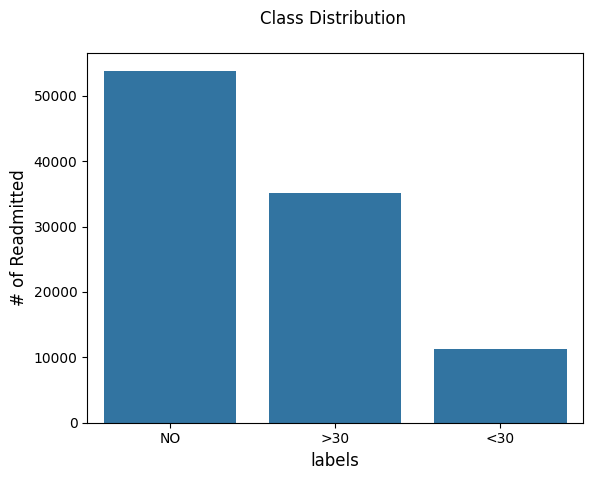

In [25]:
ax = sns.barplot(x=df['readmitted'].value_counts().index,   y=df['readmitted'].value_counts())
plt.xlabel('labels', size = 12)
plt.ylabel('# of Readmitted', size = 12)
plt.title('Class Distribution \n', size = 12)
plt.show()

We can see that There is a class imbalance since the "yes" is divided into 2 classes before and after 30 days

In [57]:
# To solve the issue we will re grooup all the yes into one
def check_label(text):
    if text == '>30' or text =='<30':
        return 'Yes'
    else:
        return 'No'

df['readmitted'] =df['readmitted'].apply(check_label)

In [58]:
df['readmitted'].value_counts()

readmitted
No     53821
Yes    46423
Name: count, dtype: int64

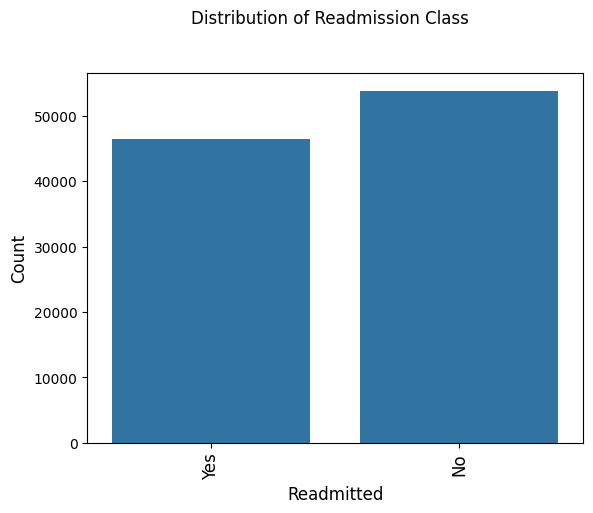

In [28]:
ax = sns.countplot(x='readmitted',   data= df)
plt.xlabel('Readmitted', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('Distribution of Readmission Class  \n\n', size = 12)
plt.show()

We can see that it fixd the class imbalance while also alligning with our goal to preddict whether the patient will be readmitted or not

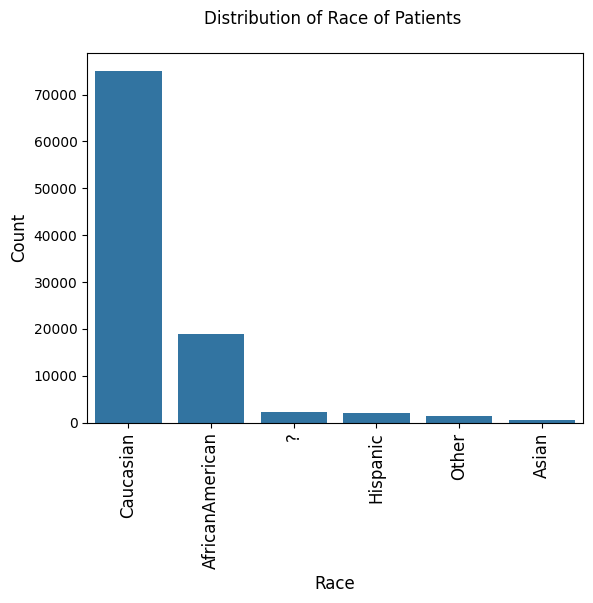

In [29]:
ax = sns.barplot(x=df['race'].value_counts().index,   y=df['race'].value_counts())
plt.xlabel('Race', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('Distribution of Race of Patients \n', size = 12)
plt.show()

In [59]:
#Chang the ? to other
df.loc[df['race'] == '?', 'race'] = 'Other'

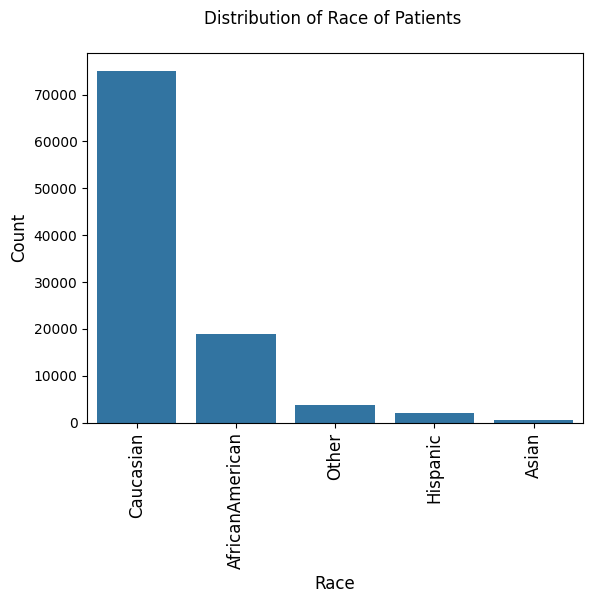

In [31]:
ax = sns.barplot(x=df['race'].value_counts().index,   y=df['race'].value_counts())
plt.xlabel('Race', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('Distribution of Race of Patients \n', size = 12)
plt.show()

We replaced the Race containing value '?' with Other!

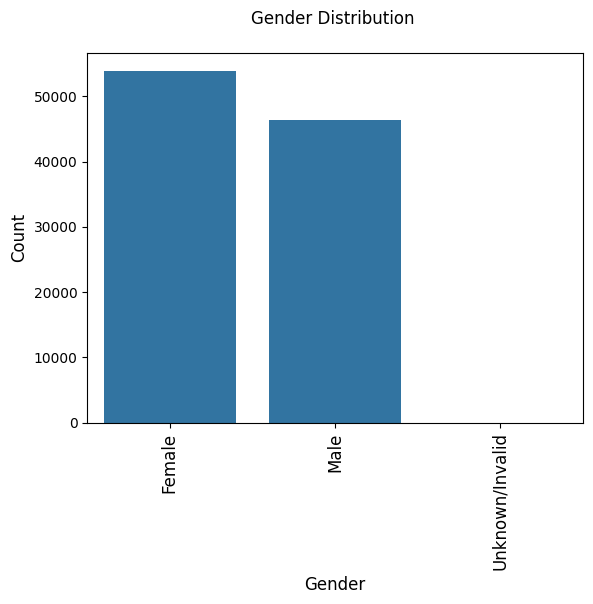

In [32]:
ax = sns.countplot(x='gender',   data= df)
plt.xlabel('Gender', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('Gender Distribution \n', size = 12)
plt.show()

In [33]:
df['gender'].value_counts()

,count
gender,
Female,53922
Male,46319
Unknown/Invalid,3


we can see that there are 3 rows unknown so it is preferrable to drop them

In [60]:
# Drop the "Unknown/Invalid" gender of the data.
df.drop(df[df['gender'] == 'Unknown/Invalid'].index, inplace = True)

In [61]:
df.reset_index(inplace = True, drop = True)

In [62]:
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,149190,55629189,Caucasian,Female,[10-20),Emergency,Discharged to home,Emergency Room,3,59,...,No,Up,No,No,No,No,No,Ch,Yes,Yes
1,64410,86047875,AfricanAmerican,Female,[20-30),Emergency,Discharged to home,Emergency Room,2,11,...,No,No,No,No,No,No,No,No,Yes,No
2,500364,82442376,Caucasian,Male,[30-40),Emergency,Discharged to home,Emergency Room,2,44,...,No,Up,No,No,No,No,No,Ch,Yes,No
3,16680,42519267,Caucasian,Male,[40-50),Emergency,Discharged to home,Emergency Room,1,51,...,No,Steady,No,No,No,No,No,Ch,Yes,No
4,35754,82637451,Caucasian,Male,[50-60),Urgent,Discharged to home,Clinic Referral,3,31,...,No,Steady,No,No,No,No,No,No,Yes,Yes


<b>Gender vs Readmittion</b>

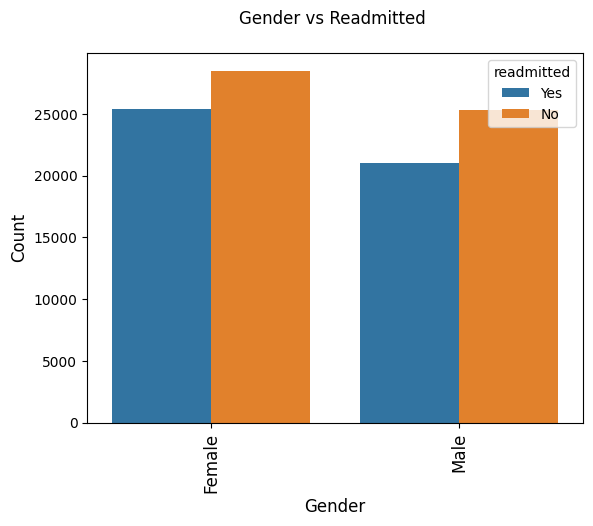

In [37]:
ax = sns.countplot(x="gender", hue="readmitted", data=df)
plt.xlabel('Gender', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('Gender vs Readmitted \n', size = 12)
plt.show()

<b>What Age of People are there in data?</b>

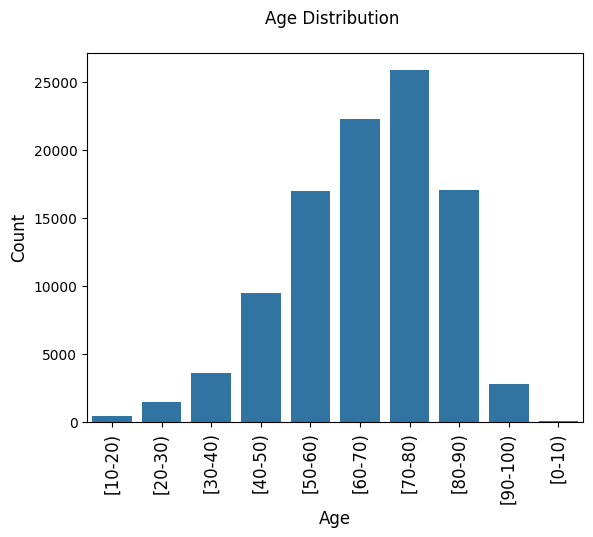

In [38]:
ax = sns.countplot(x='age',   data= df)
plt.xlabel('Age', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('Age Distribution \n', size = 12)
plt.show()

Reasonable distribution since we are working on a hospital data , backed up by the documentation as well

<b>RelationShip Between and Age and Readmission ? </b>

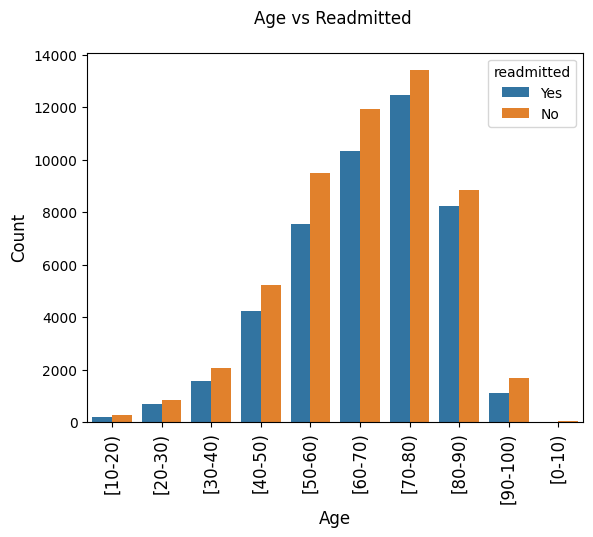

In [39]:
ax = sns.countplot(x="age", hue="readmitted", data=df)
plt.xlabel('Age', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('Age vs Readmitted \n', size = 12)
plt.show()

- As we mentioned above, The relationship of older Patients and Readmission is Strong as Mostly Older Patients are at high risk of Readmission.

- And you can also see from the data the Mostly Older Patient are Readmitted, and younger people not tend to readmit.

<b>Understanding of admission_type_id column.</b>

As per the documentation, Integer identifier corresponding to 6 distinct values, for example:
- emergency
- urgent
- elective
- newborn
- not available
- Trauma Center

This represents the Type of Admission of the Patient, Which means in which department patient if admitted to at the time of encounter.

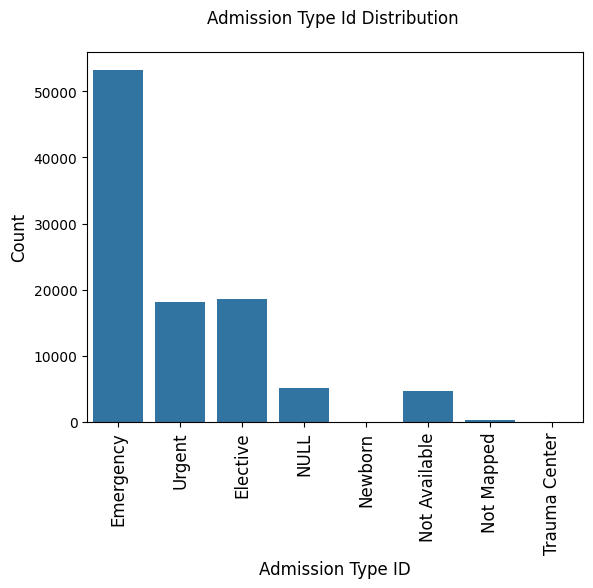

In [40]:
ax = sns.countplot(x='admission_type_id',   data= df)
plt.xlabel('Admission Type ID', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('Admission Type Id Distribution \n', size = 12)
plt.show()

In [26]:
df['admission_type_id'].unique()

array(['Emergency', 'Urgent', 'Elective', 'NULL', 'Newborn',
       'Not Available', 'Not Mapped', 'Trauma Center'], dtype=object)

<b>What is the Discharge Disposition ?</b>

AS per the Documentation, Integer identifier corresponding to 29 distinct values, for example:
- discharged to home
- expired
- not available

As per Literature, The Discharge Disposition means the facility to which patinet is discharged to. Patient can discharge to Home Health, etc.

In [41]:
df['discharge_disposition_id'].unique()

array(['Discharged to home', 'Discharged/transferred to SNF',
       'Discharged/transferred to home with home health service',
       'Discharged/transferred to another short term hospital',
       'Discharged/transferred to another type of inpatient care institution',
       'Expired', 'Left AMA', 'Not Mapped',
       'Neonate discharged to another hospital for neonatal aftercare',
       'Discharged/transferred to ICF', 'Hospice / medical facility',
       'NULL',
       'Discharged/transferred to home under care of Home IV provider',
       'Hospice / home',
       'Still patient or expected to return for outpatient services',
       'Discharged/transferred/referred another institution for outpatient services',
       'Discharged/transferred/referred to this institution for outpatient services',
       'Discharged/transferred to another rehab fac including rehab units of a hospital .',
       'Discharged/transferred to a long term care hospital.',
       'Admitted as an inpatient t

There are 26 Discharge Disposition's in the data and we also dont have mapping for it.

<b>What is Admission Source ID? </b>


As per the Literature, Integer identifier corresponding to 21 distinct values, for example:
- physician referral,
- emergency room,  
- transfer from a hospital

Admission Source means, from which source the patient came? The Patient can come from Physician Referral and other Sources.

In [42]:
df['admission_source_id'].unique()

array([' Emergency Room', 'Clinic Referral', 'Transfer from a hospital',
       ' Physician Referral',
       ' Transfer from a Skilled Nursing Facility (SNF)',
       ' Transfer from another health care facility', ' Not Mapped',
       'HMO Referral', 'NULL', ' Court/Law Enforcement', ' Not Available',
       ' Extramural Birth', ' Transfer from critial access hospital',
       ' Transfer from hospital inpt/same fac reslt in a sep claim',
       'Normal Delivery', ' Transfer from Ambulatory Surgery Center',
       ' Sick Baby'], dtype=object)

In [63]:
print('There are', len(df['admission_source_id'].unique()), 'unique Admission Sources from which patient can be admitted.')

There are 17 unique Admission Sources from which patient can be admitted.


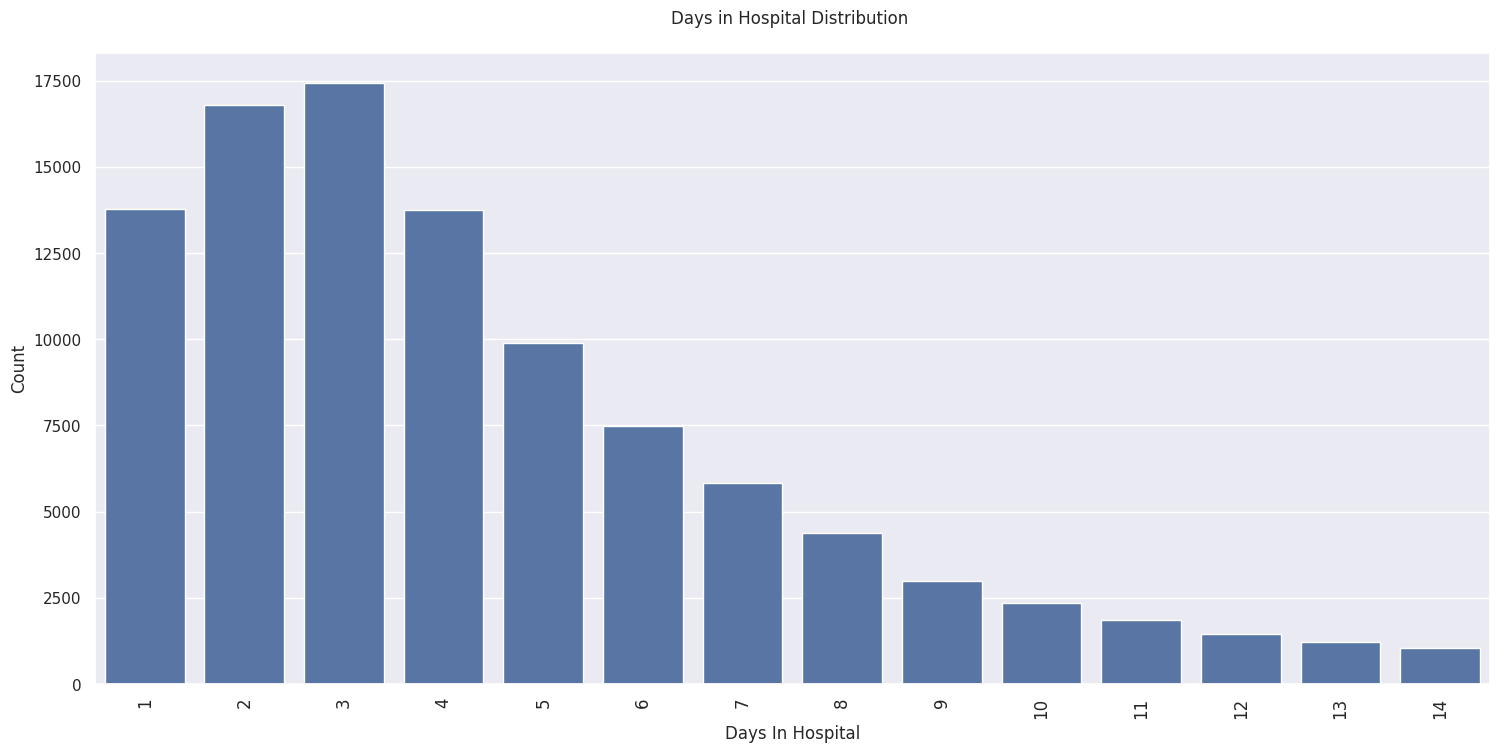

In [44]:
sns.set(rc={'figure.figsize':(18,8.2)})
ax = sns.countplot(x='time_in_hospital',   data= df)
plt.xlabel('Days In Hospital', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('Days in Hospital Distribution \n', size = 12)
plt.show()

In [45]:
df['time_in_hospital'].mean()

np.float64(4.4203070599854355)

From the Graph and Mean of the Time in Hospital, We found that the majority of the people stays in hospital 2-4 Days.

Time vs readmission???

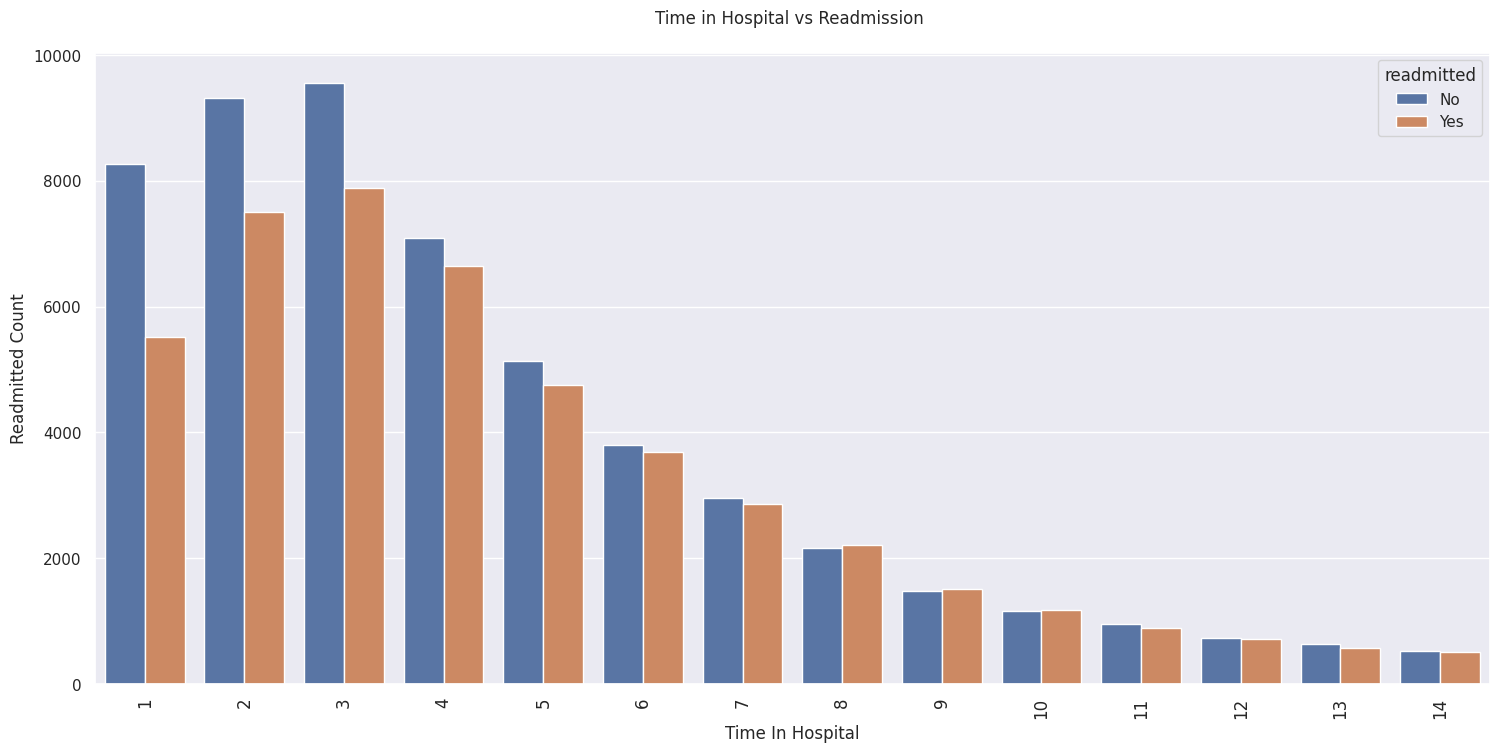

In [46]:
sns.set(rc={'figure.figsize':(18,8.2)})
ax = sns.countplot(x='time_in_hospital',  hue= 'readmitted',  data= df)
plt.xlabel('Time In Hospital', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Readmitted Count', size = 12)
plt.title('Time in Hospital vs Readmission \n', size = 12)
plt.show()

We can see that the longer the patient stayed in the hospital the lower the possibility of addmision and vise versa

<b> What is payer Code ?</b>

From the Literature, Integer identifier corresponding to 23 distinct values, for example:

- Blue Cross\BlueShield
- Medicare,
- self-pay

This represent the payer of bill at the hospital.

Verifying what we found in the beggining as well, we have almost half the data is missing , and this is the type of how the patient payed which isnt really relevant to the readmission; so we will remove

<b>What is num_lab_procedures ? </b>

Number of lab tests performed during the encounter


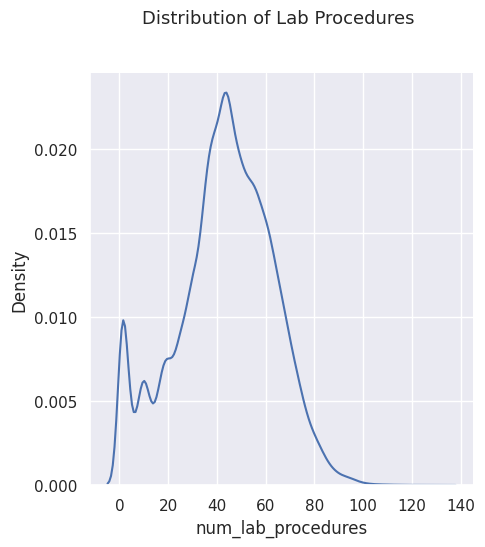

In [47]:
sns.displot(df, x="num_lab_procedures", kind="kde")
plt.title('Distribution of Lab Procedures \n\n', size = 13)
plt.show()

-  As we can see that from the distribution plot. That the majority of the Patients have around 30 to 50 Labs Procedures. Lets look at it with respect to class.   

<b>Trend of Lab Procedures with Readmission ?</b>

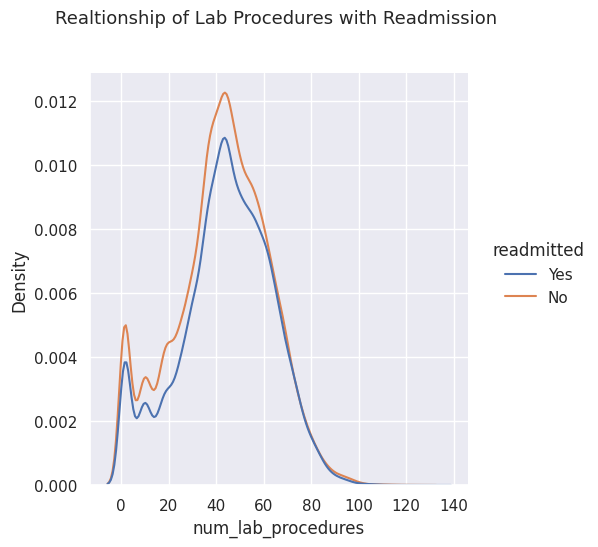

In [48]:
sns.displot(df, x="num_lab_procedures", hue= 'readmitted', kind="kde")
plt.title('Realtionship of Lab Procedures with Readmission \n\n', size = 13)
plt.show()

- The Distribution of Readmitted and Not Readmitted have the same trend.
- The number of labs procedures will not play a vital role in creating contrastive behaviour between Readmitted and Not Readmitted.

<b>What is the relation of Number of Procedures and Readmission? </b>

Number of procedures (other than lab tests) performed during the encounter

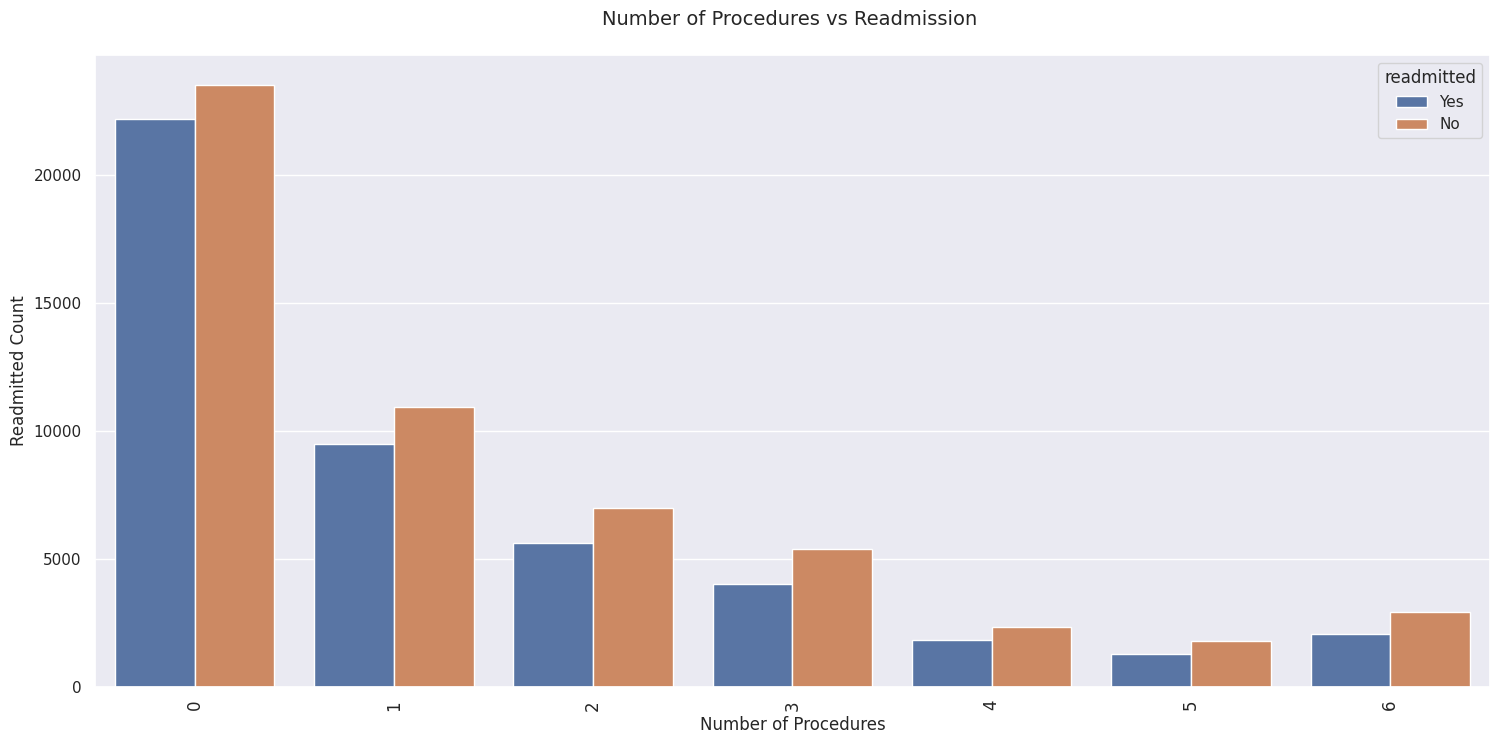

In [49]:
sns.set(rc={'figure.figsize':(18,8.2)})
ax = sns.countplot(x='num_procedures',  hue= 'readmitted',  data= df)
plt.xlabel('Number of Procedures', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Readmitted Count', size = 12)
plt.title('Number of Procedures vs Readmission \n', size = 14)
plt.show()

- Number of Procedures is also not giving some vital signs of readmission with increase in procedure.
- Majority of patients have 0 procedures which are can be Readmitted and not Readmitted

<b>What is the contribution of num_medications in the data? </b>

Number of distinct generic names administered during the encounter

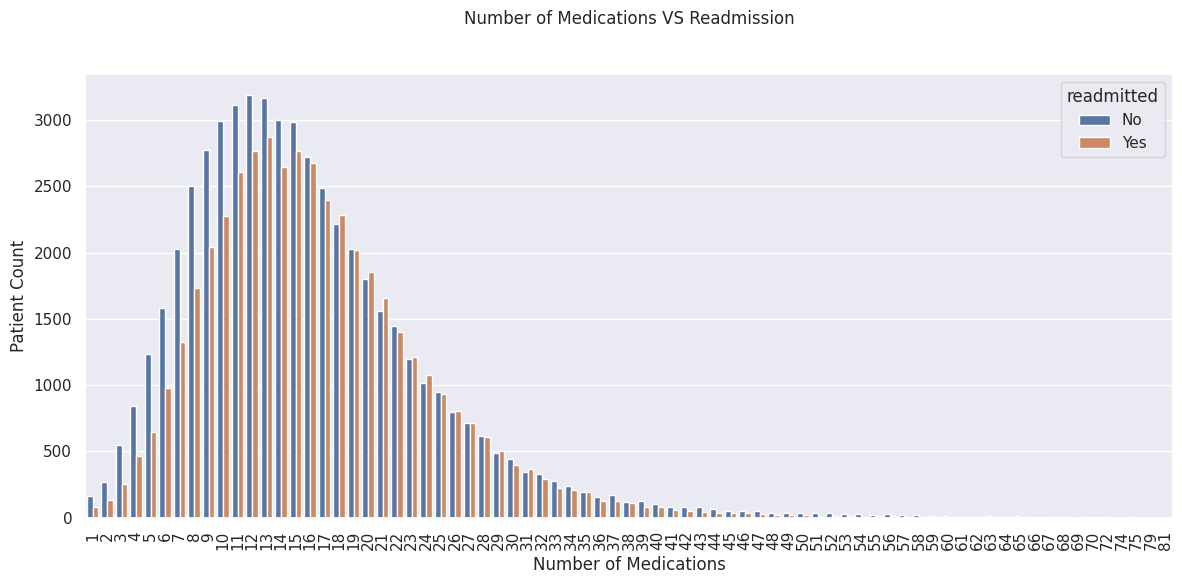

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt



plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="num_medications", hue="readmitted")
plt.title('Number of Medications VS Readmission\n\n')
plt.xlabel("Number of Medications")
plt.ylabel("Patient Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


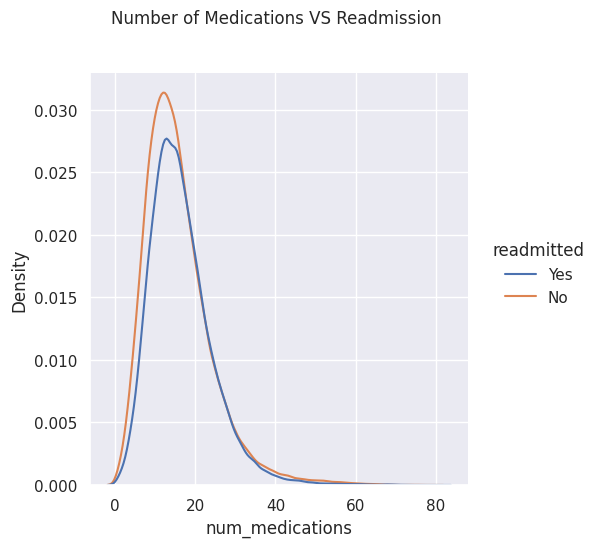

In [51]:
sns.displot(df, x="num_medications", hue= 'readmitted', kind="kde")
plt.title('Number of Medications VS Readmission \n\n')
plt.show()

ARGUMENTTT

<b>What is the trend of Outpatient Visits vs Readmission? </b>



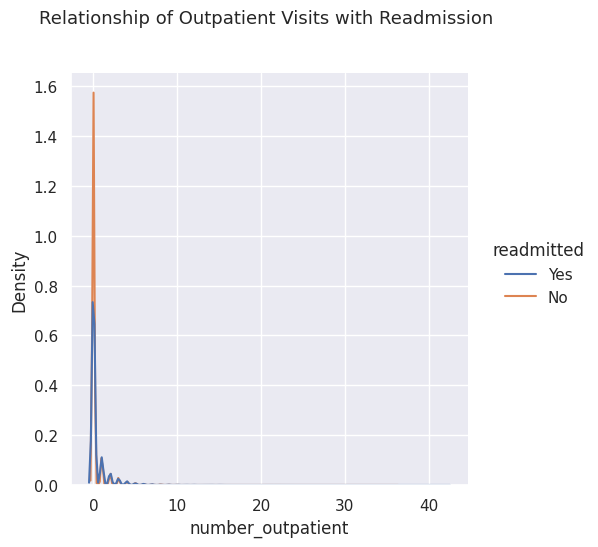

In [52]:
sns.displot(df, x="number_outpatient", hue= 'readmitted', kind ='kde')
plt.title('Relationship of Outpatient Visits with Readmission \n\n', size = 13)
plt.show()

There is skewness so we need to slice to see deeper insight

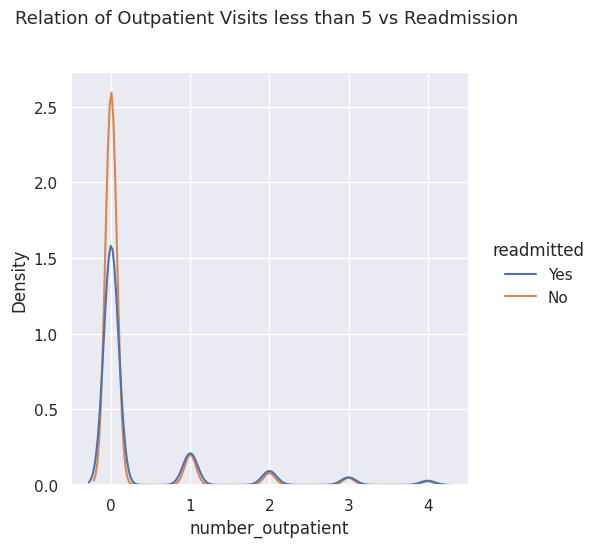

In [53]:
sns.displot(df.loc[df['number_outpatient']<5], x="number_outpatient", hue= 'readmitted', kind ='kde')
plt.title('Relation of Outpatient Visits less than 5 vs Readmission \n\n', size = 13)
plt.show()

We Identfied that the Patients with Outpatient Visits at 0, Normally not Readmitted.

<b> First of all look at Outpatient Visits above 5. </b>

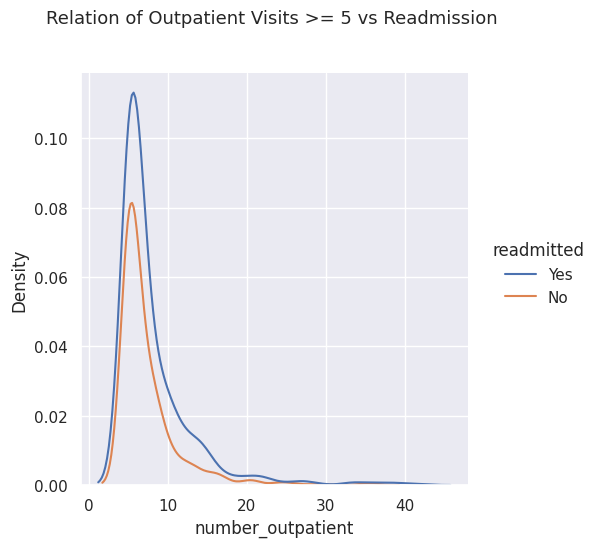

In [54]:
sns.displot(df.loc[df['number_outpatient']>=5], x="number_outpatient", hue= 'readmitted', kind ='kde')
plt.title('Relation of Outpatient Visits >= 5 vs Readmission \n\n', size = 13)
plt.show()

- On the Data with Outpatient Visits greater than equal to 5, we most likely to see that more people readmitted then not readmitted.
- We can conclude that this feature on some range will give us more important rules.

<b> What is the trend of Number of Emergency Visits ?</b>

Number of emergency visits of the patient in the year preceding the encounter

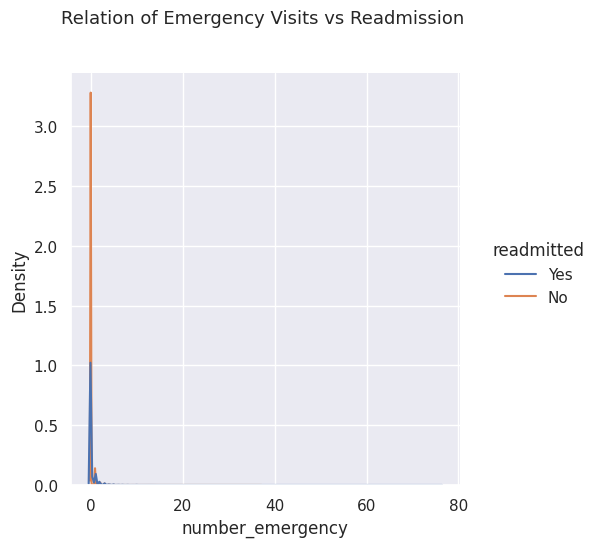

In [55]:
sns.displot(df, x="number_emergency", hue= 'readmitted', kind='kde')
plt.title('Relation of Emergency Visits vs Readmission \n\n', size = 13)
plt.show()

- We can see that the distribution of Emergnecy Visits very Skewed.
- Majority of the Patients have 0 Emergency `Visits.
- We will slice the data and look for trend in detail.

<b> What is relation when we look at Emergency Visits less than 5 ? <b>

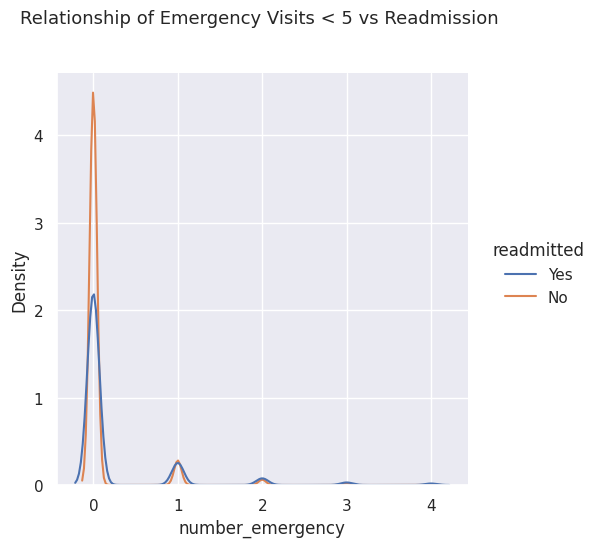

In [56]:
sns.displot(df.loc[df['number_emergency']<5], x="number_emergency", hue= 'readmitted', kind='kde')
plt.title('Relationship of Emergency Visits < 5 vs Readmission \n\n', size = 13)
plt.show()

- When the value is at 0 the number of Not Readmitted are higher than the Readmitted Patients.
- Now lets look at the patients with readmission greater than equal to 5.

<b> What is relation when we look at Emergency Visits greater than 5 ? <b>

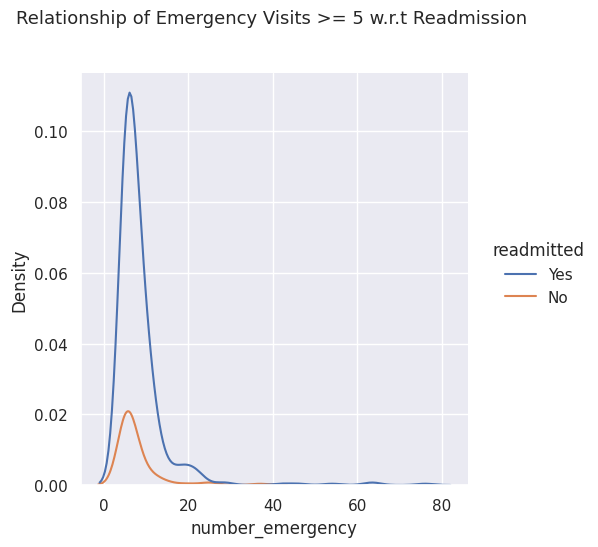

In [57]:
sns.displot(df.loc[df['number_emergency']>=5], x="number_emergency", hue= 'readmitted', kind='kde')
plt.title('Relationship of Emergency Visits >= 5 w.r.t Readmission \n\n', size = 13)
plt.show()

- We can see that The majority of the Encouters have Number of Readmission Visits nea 10 and they are Readmitted to hospital.
- We can conclude that, if the Numer of emergency Visits Increased the Patient Most likely to readmit to the hospital.

<b>What is the pattern of Number of Inpatient Visits ? </b>

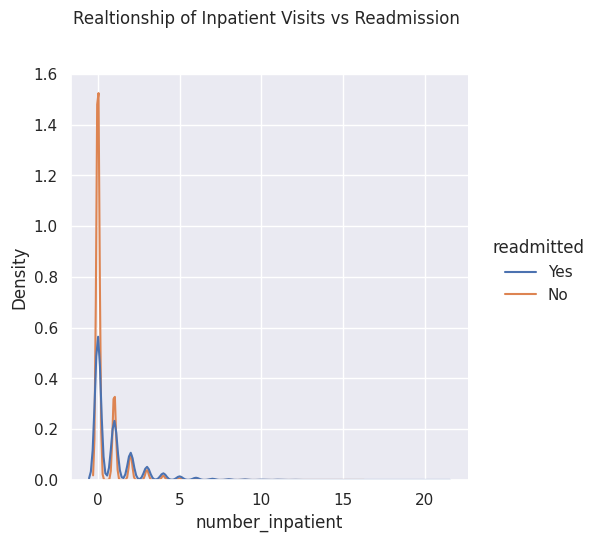

In [58]:
sns.displot(df, x="number_inpatient", hue= 'readmitted', kind='kde')
plt.title('Realtionship of Inpatient Visits vs Readmission \n\n')
plt.show()

- We can see from above graph, the Inpatinet Readmission also lies at 0 for majority of Patients.
- Now we drill down Number of Inpatient for better undetstanding.

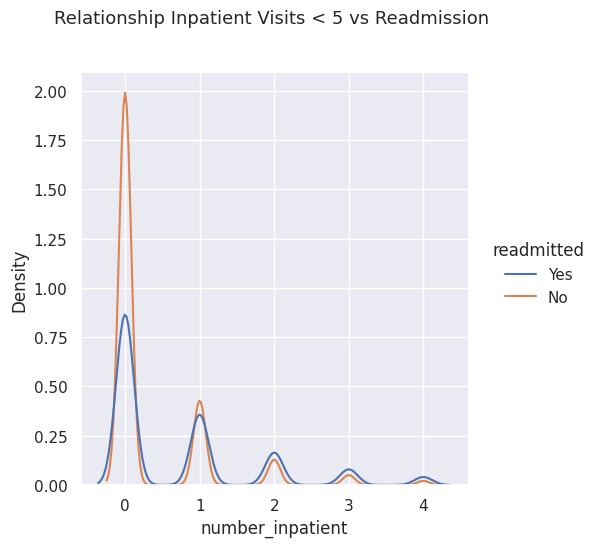

In [59]:
sns.displot(df.loc[df['number_inpatient']<5], x="number_inpatient", hue= 'readmitted', kind='kde')
plt.title('Relationship Inpatient Visits < 5 vs Readmission \n\n', size = 13)
plt.show()

- From above graph, we see that if the patient comes in Inpatient Facility from 0-5 Times it will not readmitted.
- Also the majority of patients have 0 Inpatient Encounters.


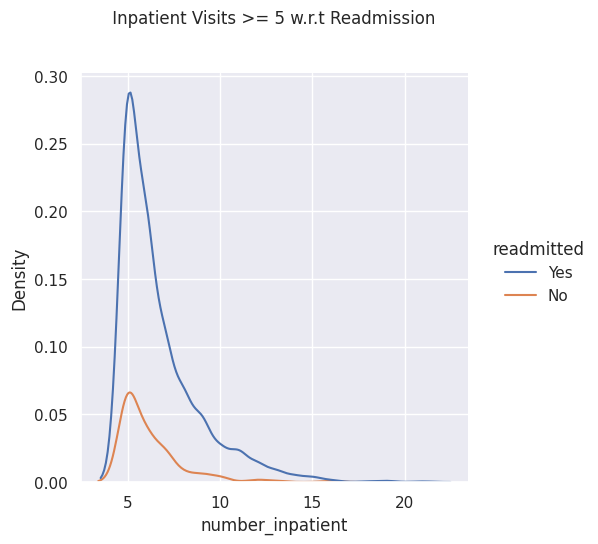

In [60]:
sns.displot(df.loc[df['number_inpatient']>=5], x="number_inpatient", hue= 'readmitted', kind='kde')
plt.title(' Inpatient Visits >= 5 w.r.t Readmission \n\n')
plt.show()

Now, if we look at the data for Inpatinet Visits greater than equal to 5, the patients most likeyly to Readmit to the hospital and it will become the deciding criteria for the model.

<b>What are Diag_1, Diag_2 and Diag_3. ?</b>

- There are three column which contains the diagnosis code for the Encounter.
- Each time the patient admits to the hospital, A diagnosis code is assign with it.
- Which means on which problem the patient comes to the hospital.

- <b>Diagnosis 1 </b> :Nominal The primary diagnosis (coded as first three digits of ICD9); 848
- <b>Diagnosis 2 </b> :Nominal Secondary diagnosis (coded as first three digits of ICD9); 923
- <b>Diagnosis 3 </b> :Nominal Additional secondary diagnosis (coded as first three digits of ICD9); 954 distinct
values

As per the Documentation, they are the ICD - 9 Coded Diagnosis Codes, Each code represents some Disease.
- The diag_1 is the Primary Diagnosis of the Patient, which means the patient is admitted to the hospital on this diagnosis.
- The diag_2 is the Secondary Diagnosis, According to CMS Documentation  "Secondary diagnoses are “conditions that coexist at the time of admission, that develop subsequently, or that affect the treatment received and/or length of stay. These diagnoses are vital to documentation and have the potential to impact a patient's severity of illness and risk of mortality"
- The diag_2 is the Additional Secondary Diagnosis.

In [61]:
len(df['diag_1'].unique()), len(df['diag_2'].unique()), len(df['diag_3'].unique())

(715, 743, 789)

<b> As the unique values are too much. We can analyze the Top Diagnosis in Each Class!</b>

In [62]:
df[df['readmitted'] == 'Yes']['diag_1'].value_counts()

,count
diag_1,
428,4053
414,2705
786,1693
486,1679
410,1436
...,...
245,1
895,1
914,1


<b>Top 20 Diagnosis in the Readmitted = YES </b>

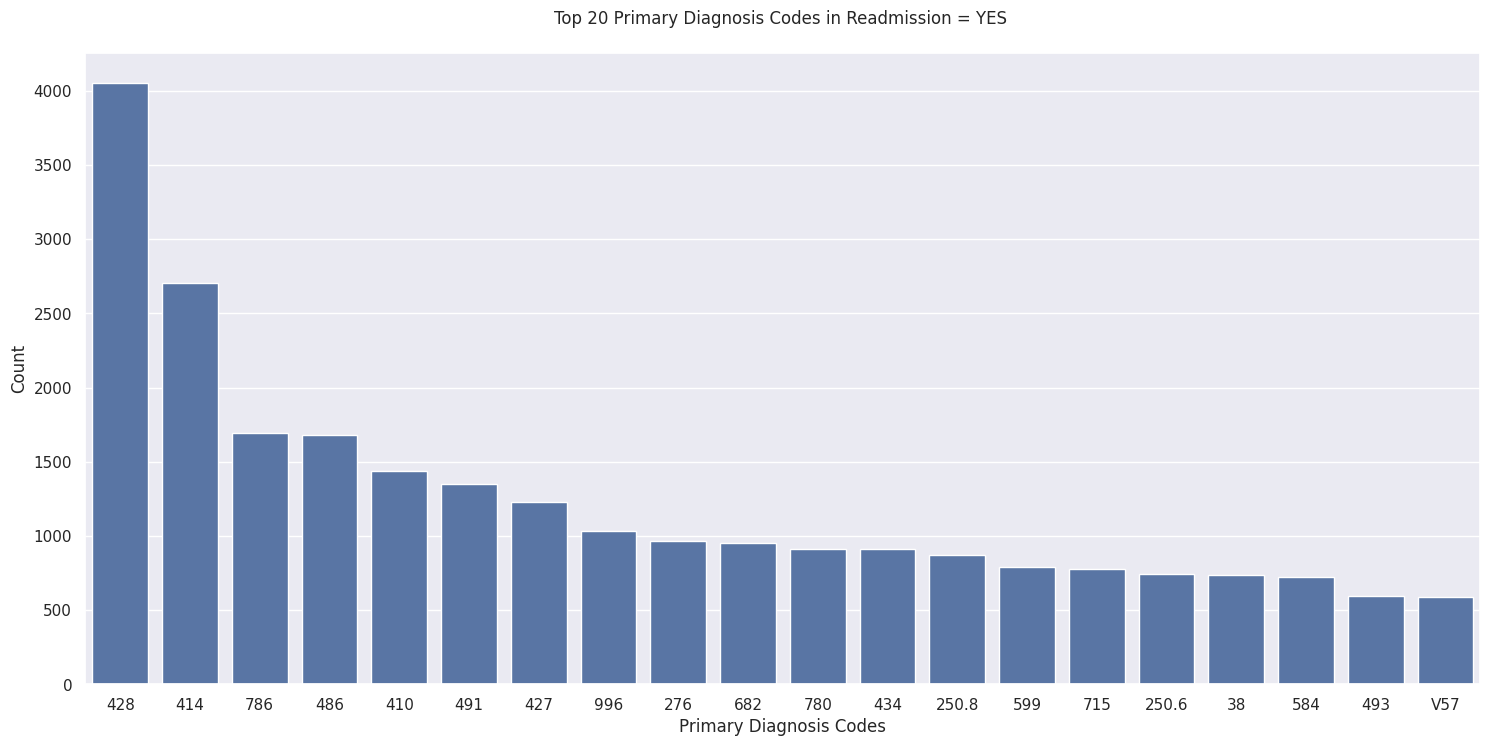

In [63]:
ax = sns.barplot(x=df[df['readmitted'] == 'Yes']['diag_1'].value_counts().index[:20],
                 y=df[df['readmitted'] == 'Yes']['diag_1'].value_counts()[:20])
plt.xlabel('Primary Diagnosis Codes', size = 12)
plt.ylabel('Count', size = 12)
plt.title('Top 20 Primary Diagnosis Codes in Readmission = YES \n', size = 12)
plt.show()

The Top Diagnosis Codes are 428, 414 and 786 in the Readmitted Patients.
If we look at the ICD-9 Dictionary we will know that,
- 428 = Congestive heart failure
- 414 = Ischemic heart disease
- 786 = Symptoms involving respiratory system and other chest symptoms
- 486 = Pneumonia, organism unspecified

So Patients with Heart Disease and Chest Disease are more likely to readmit to the hospital.

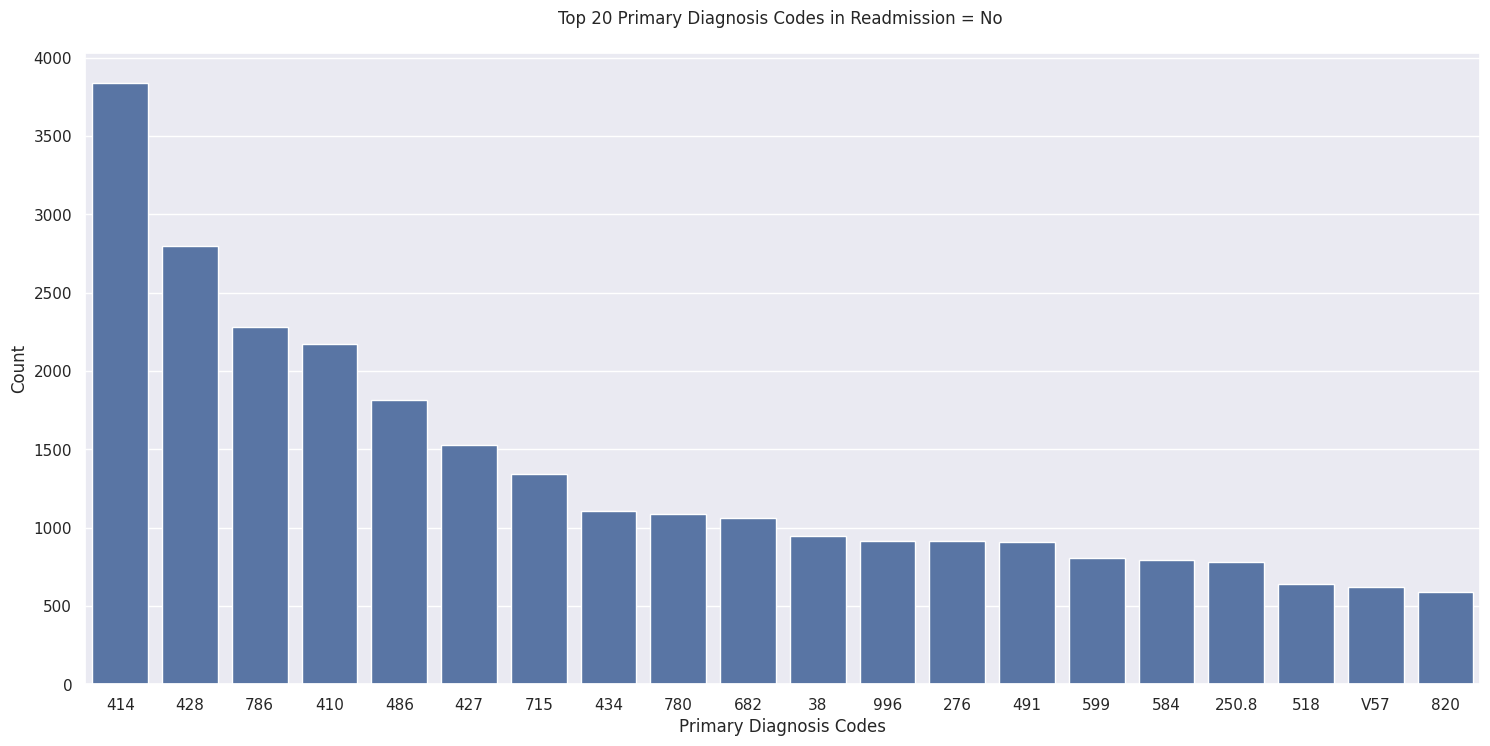

In [64]:
ax = sns.barplot(x=df[df['readmitted'] == 'No']['diag_1'].value_counts().index[:20],
                 y=df[df['readmitted'] == 'No']['diag_1'].value_counts()[:20])
plt.xlabel('Primary Diagnosis Codes', size = 12)
plt.ylabel('Count', size = 12)
plt.title('Top 20 Primary Diagnosis Codes in Readmission = No \n', size = 12)
plt.show()

https://en.wikipedia.org/wiki/List_of_ICD-9_codes
We can see from graph, Chest and Heart Diseases are also common in Patients who didnt Admitted.

<b>Lets Analyze Number of Diagnosis Column </b>

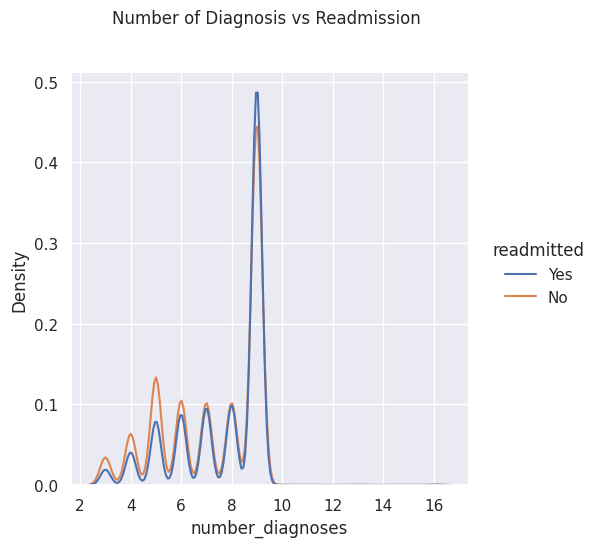

In [65]:
sns.displot(df, x="number_diagnoses", hue= 'readmitted', kind='kde')
plt.title('Number of Diagnosis vs Readmission \n\n')
plt.show()

- From Above plot we can see that, there is no clear difference in people Readmitted and Not Readmitted.
- There is some minor difference, which is at where Diagnosis between 8-10, The patient more likely to readmit.
- As the pattern for more than 10 diagnosis is hidden we will look it in detail.


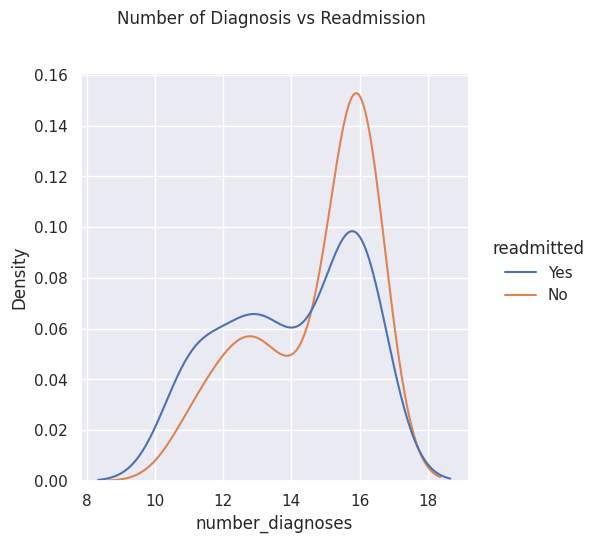

In [66]:
sns.displot(df[df['number_diagnoses']>10], x="number_diagnoses", hue= 'readmitted', kind='kde')
plt.title('Number of Diagnosis vs Readmission \n\n')
plt.show()

- The trend is same and have approximately same pattern.

<b>What is change?</b>

Indicates if there was a change in diabetic medications (either dosage or generic
name). Values:

- “change”  
- “no change”

In [67]:
df['change'].value_counts()

,count
change,
No,53891
Ch,46350


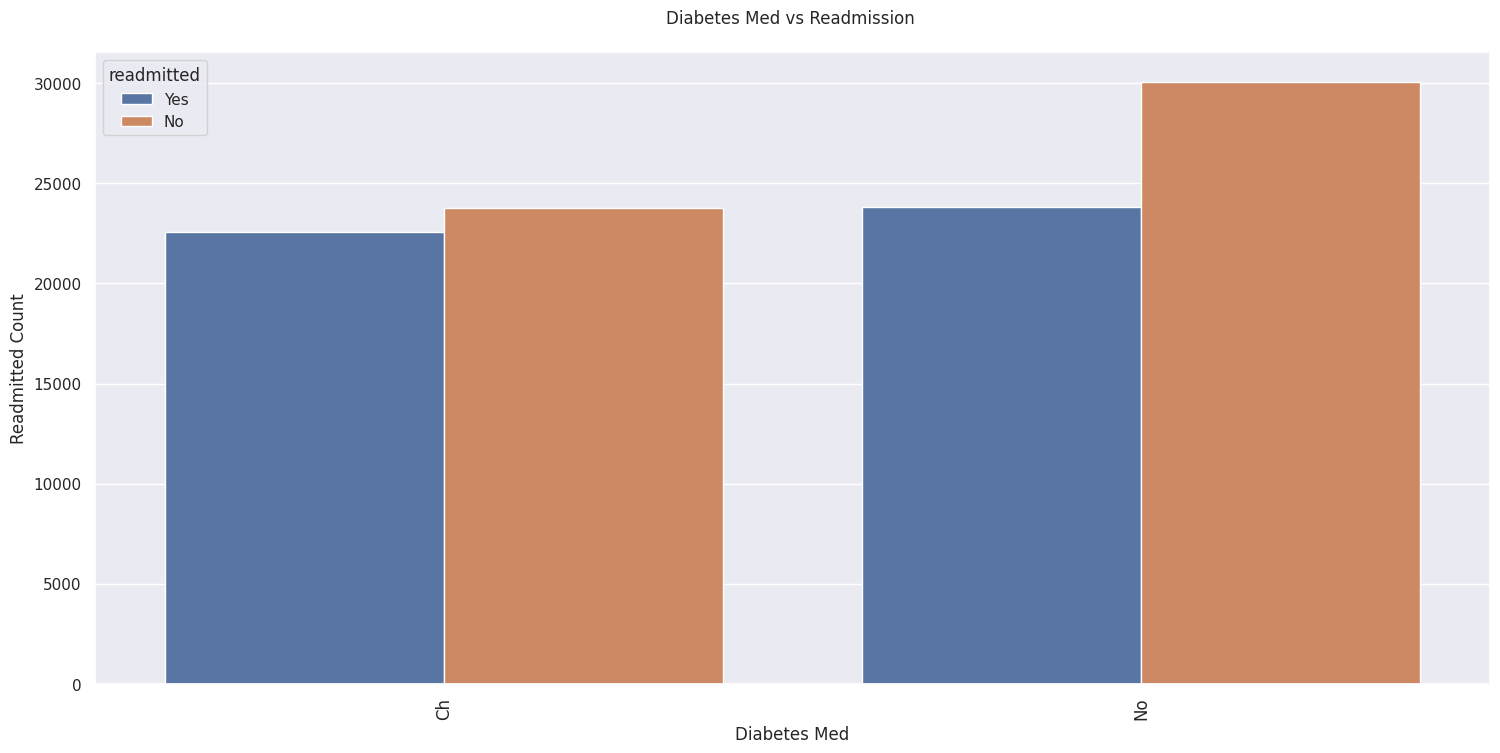

In [68]:
ax = sns.countplot(x='change',  hue= 'readmitted',  data= df)
plt.xlabel('Diabetes Med', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Readmitted Count', size = 12)
plt.title('Diabetes Med vs Readmission \n', size = 12)
plt.show()

<b>What is Diabetes Med ? </b>

Indicates if there was any diabetic medication prescribed. Values:

- “yes”
- “no”

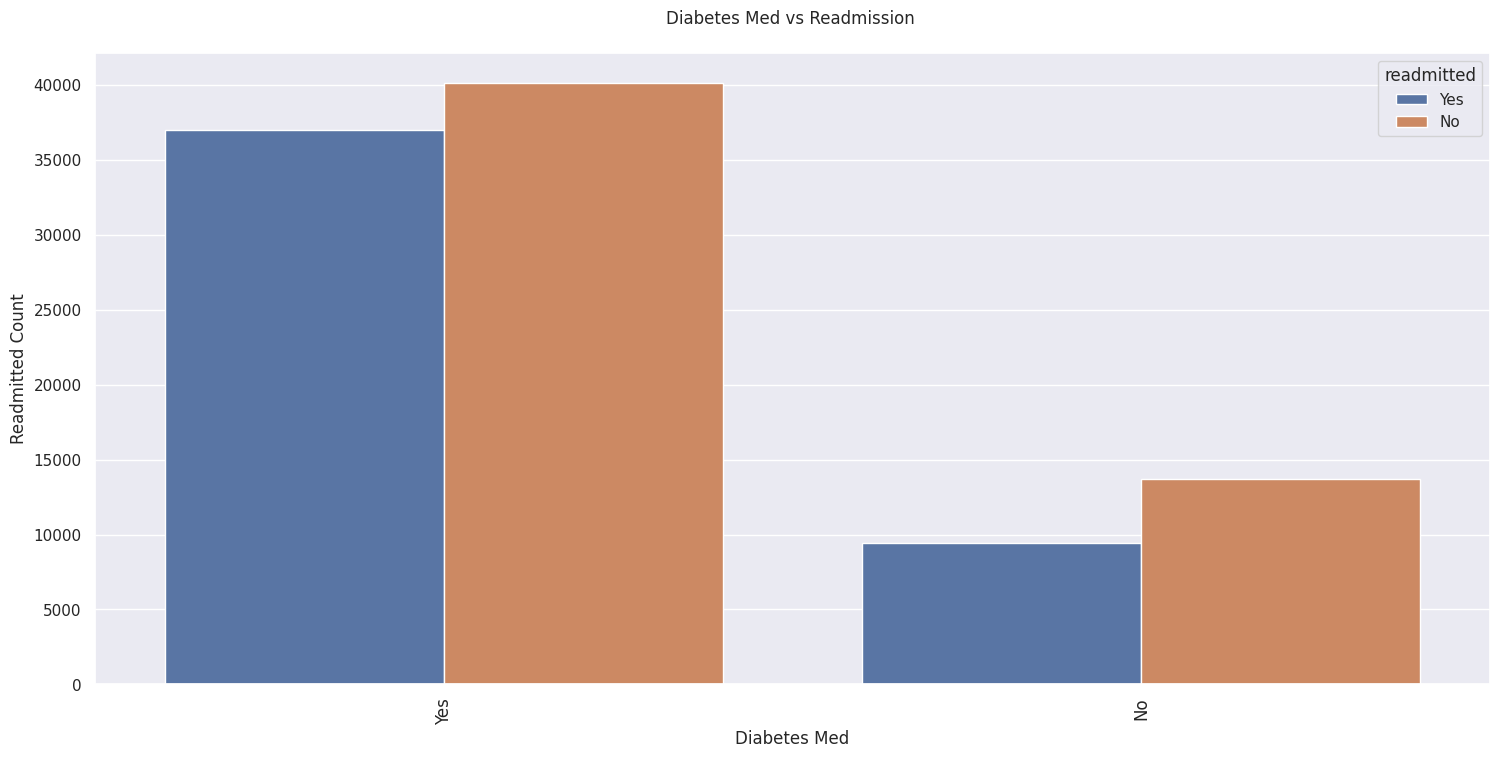

In [69]:
ax = sns.countplot(x='diabetesMed',  hue= 'readmitted',  data= df)
plt.xlabel('Diabetes Med', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Readmitted Count', size = 12)
plt.title('Diabetes Med vs Readmission \n', size = 12)
plt.show()

<b>24 Features for Medications?</b>

In [64]:
medications = df.iloc[:, 19:42].columns
medications

Index(['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone'],
      dtype='object')

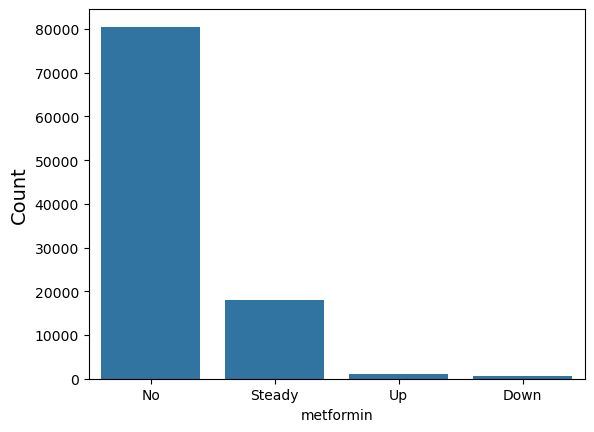

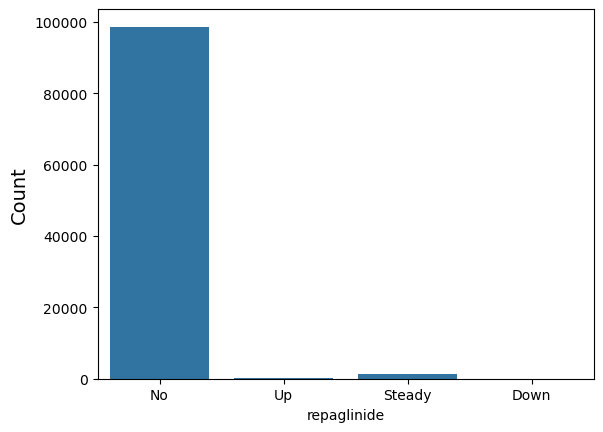

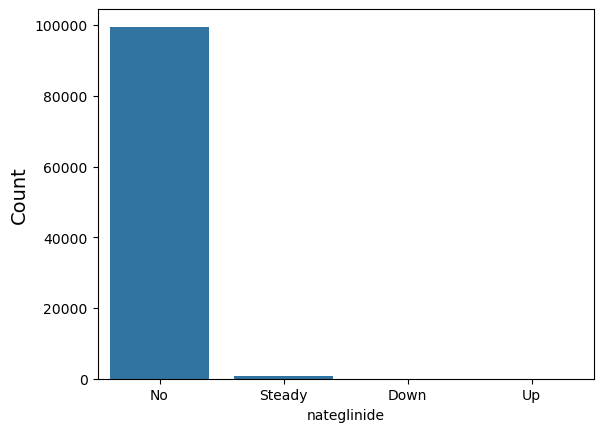

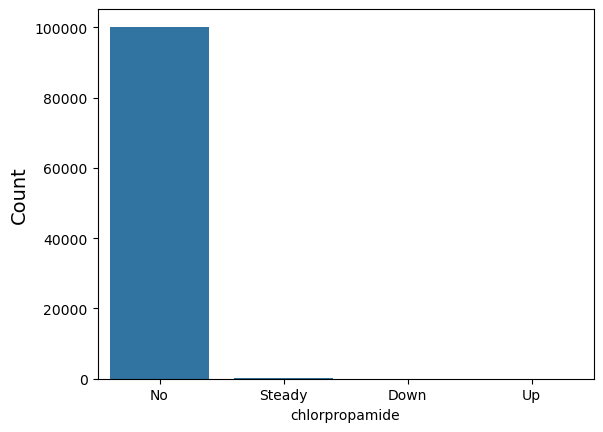

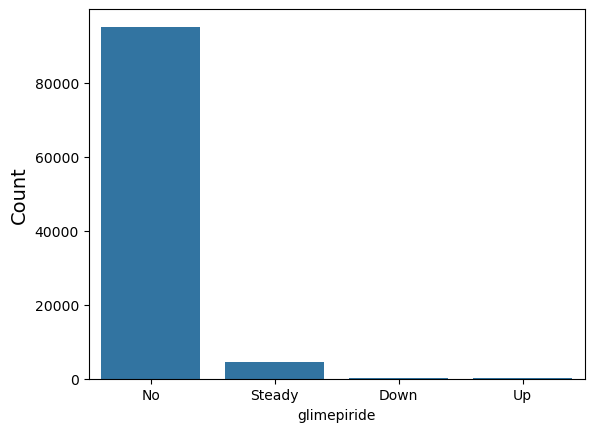

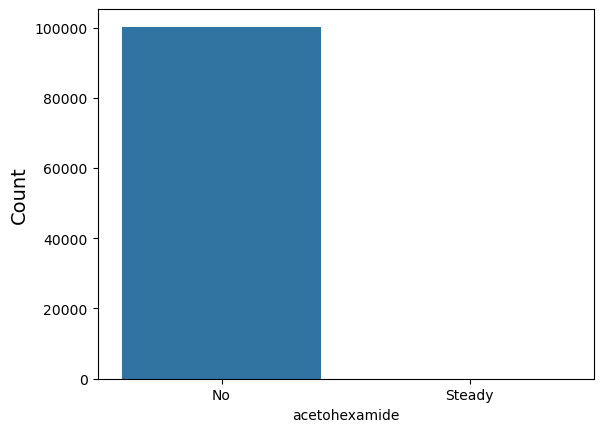

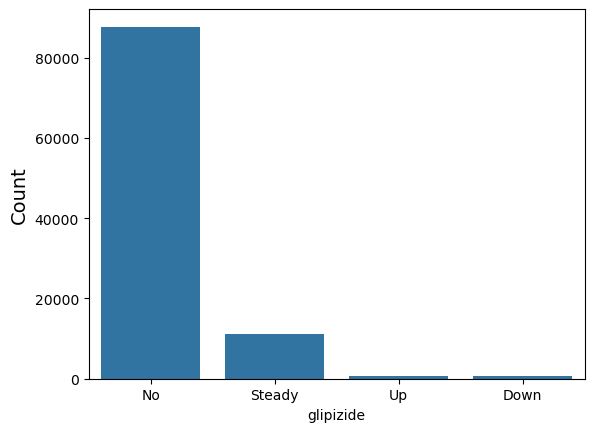

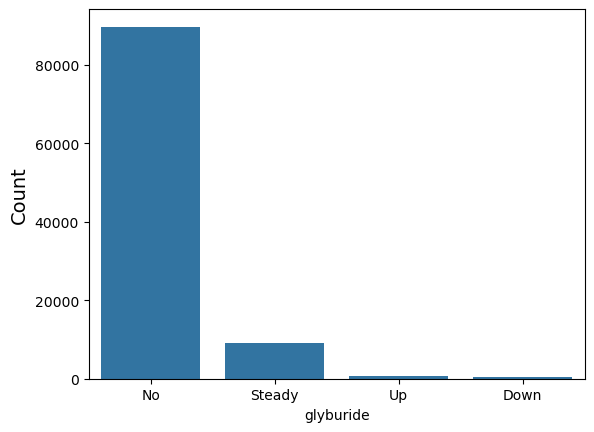

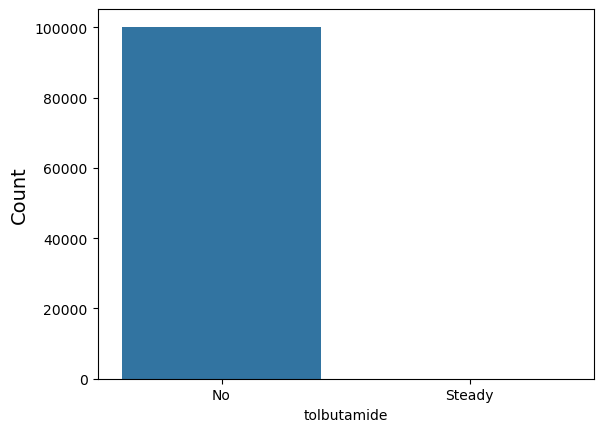

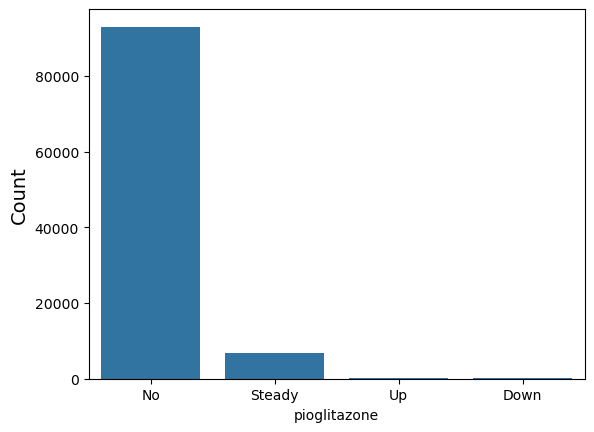

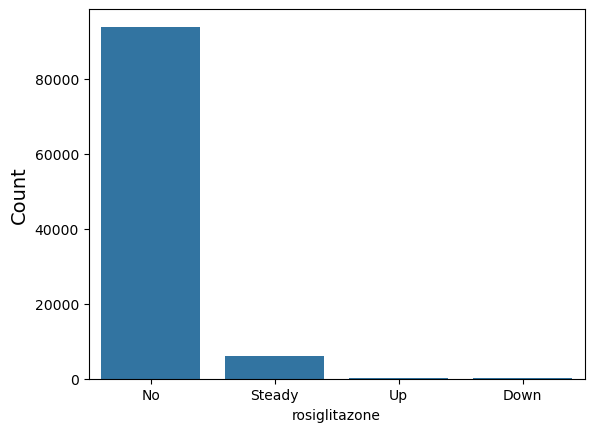

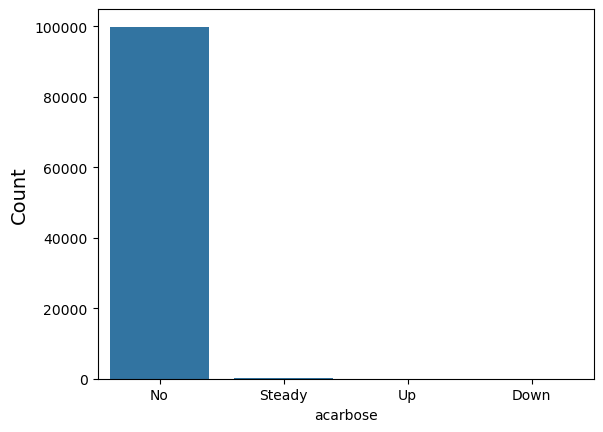

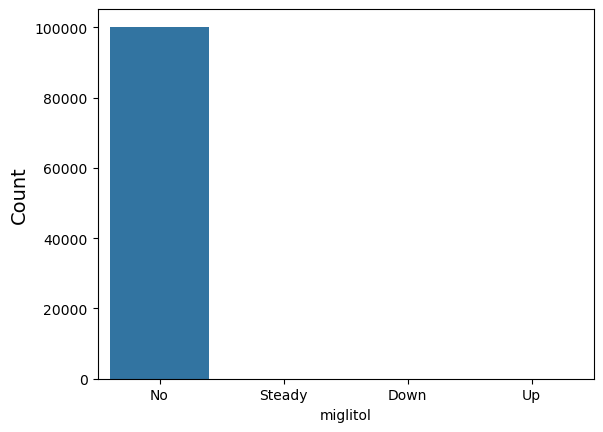

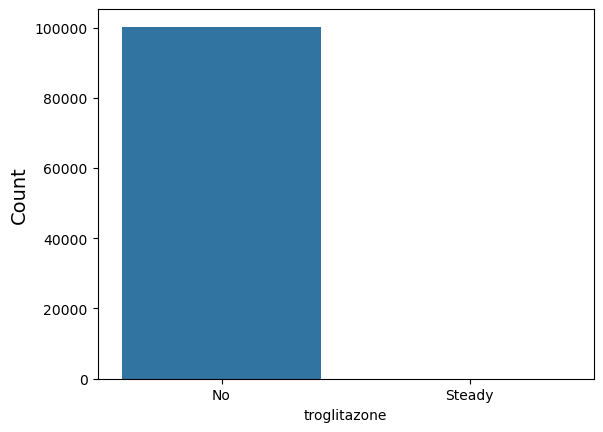

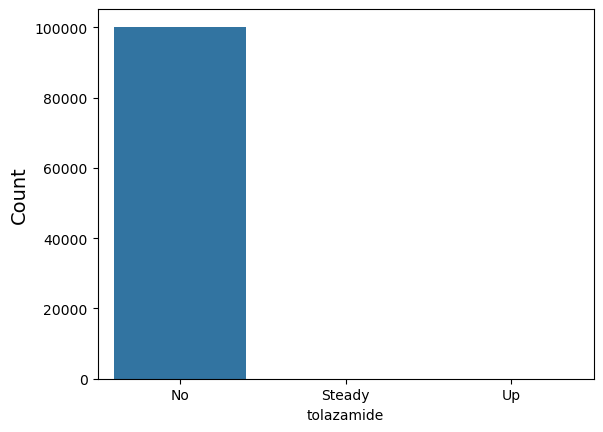

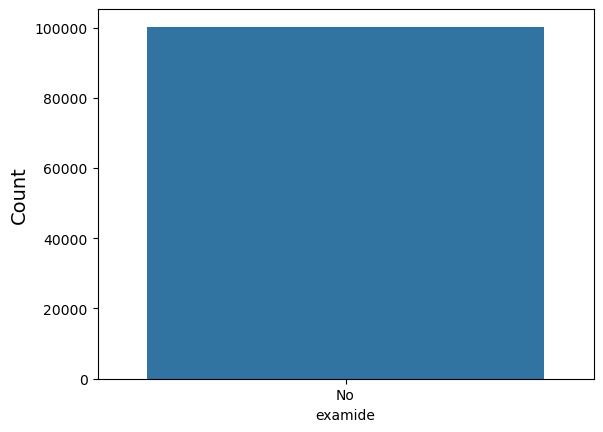

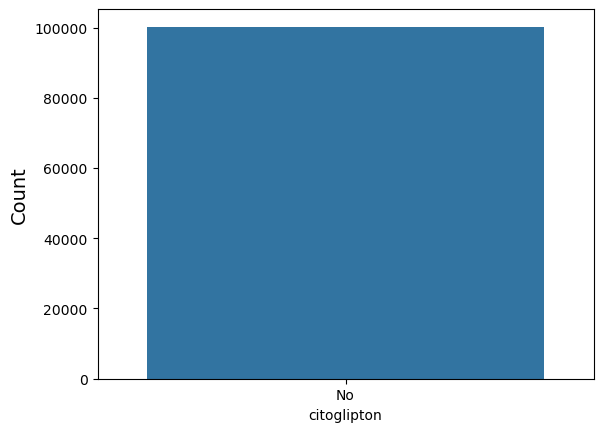

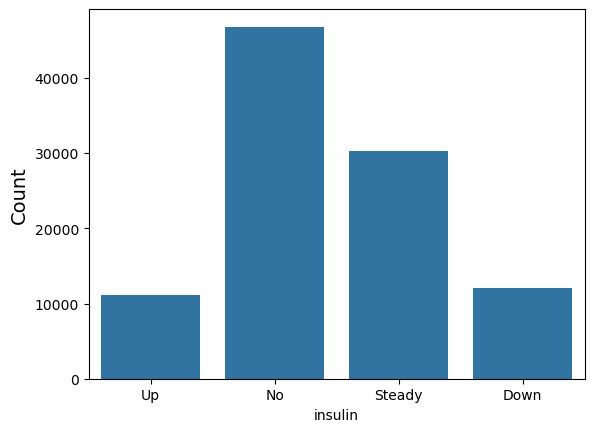

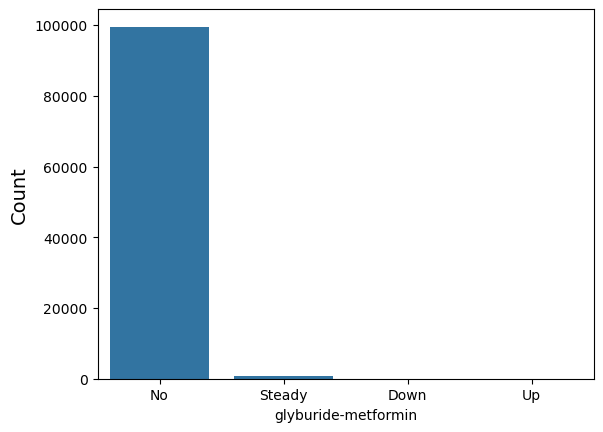

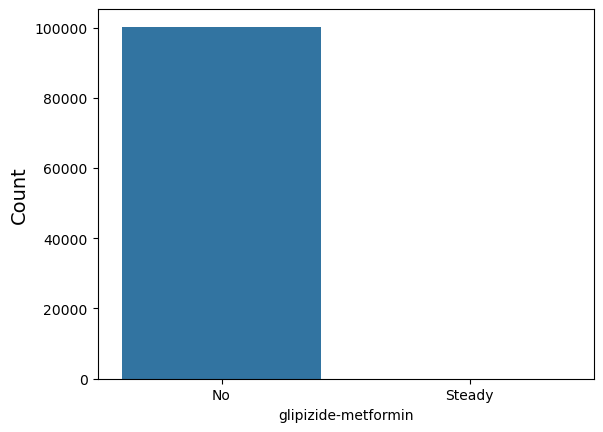

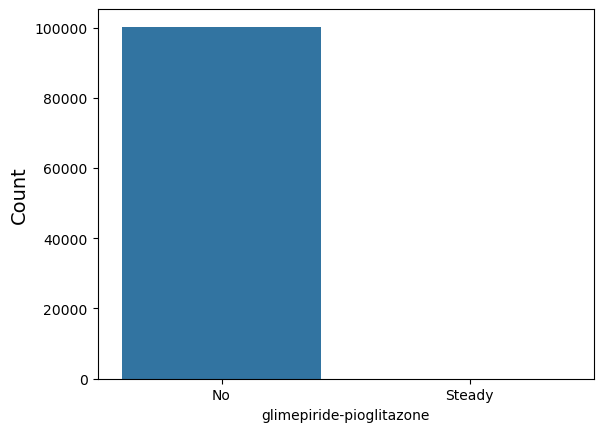

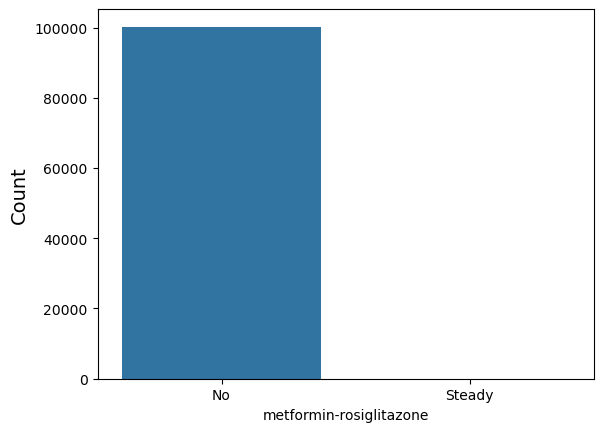

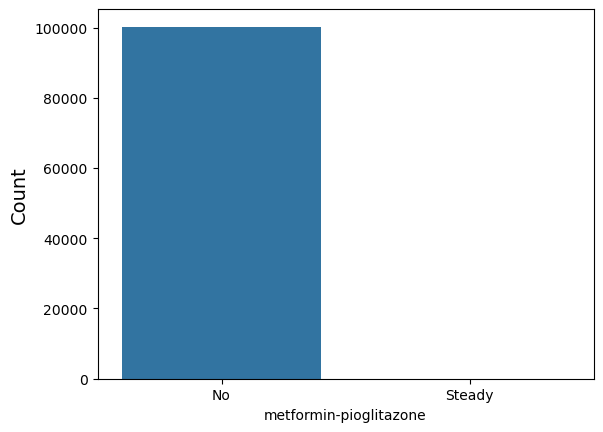

In [65]:
for i in medications:

    ax = sns.countplot(x=i, data= df)
    plt.ylabel('Count', size = 14)
    plt.show()

- From the above count plots, we can see that majority of the Medicines are not assigned to patients.
- If one is assigned then it is assigned to very few people.

<b> Analyze Medicines with Class Variable Readmission </b>

<b> Dropping Columns with almost no Information</b>

In [66]:
# List of 24 drug columns to drop
drug_columns = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
    'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
    'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
    'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin',
    'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone',
    'metformin-pioglitazone'
]

# Count the frequency of each dosage class in the 24 drug columns
drug_class_counts = df[drug_columns].apply(lambda row: row.value_counts(), axis=1).fillna(0).astype(int)

# Rename columns to reflect they are counts
drug_class_counts.columns = [f'count_{col}' for col in drug_class_counts.columns]

# Concatenate the new counts with the original dataframe
df = pd.concat([df, drug_class_counts], axis=1)

# Drop the drug columns from the DataFrame
df.drop(columns=drug_columns, inplace=True)

# Verify the result
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,diag_2,diag_3,number_diagnoses,change,diabetesMed,readmitted,count_Down,count_No,count_Steady,count_Up
0,149190,55629189,Caucasian,Female,[10-20),Emergency,Discharged to home,Emergency Room,3,59,...,250.01,255,9,Ch,Yes,Yes,0,22,0,1
1,64410,86047875,AfricanAmerican,Female,[20-30),Emergency,Discharged to home,Emergency Room,2,11,...,250,V27,6,No,Yes,No,0,22,1,0
2,500364,82442376,Caucasian,Male,[30-40),Emergency,Discharged to home,Emergency Room,2,44,...,250.43,403,7,Ch,Yes,No,0,22,0,1
3,16680,42519267,Caucasian,Male,[40-50),Emergency,Discharged to home,Emergency Room,1,51,...,157,250,5,Ch,Yes,No,0,21,2,0
4,35754,82637451,Caucasian,Male,[50-60),Urgent,Discharged to home,Clinic Referral,3,31,...,411,250,9,No,Yes,Yes,0,22,1,0


In [2]:
# df.drop(columns = ['acetohexamide', 'tolbutamide', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
#                    'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone',
#                    'metformin-pioglitazone'], inplace = True)

In [67]:
df.shape

(100241, 26)

In [29]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'insulin',
       'glyburide-metformin', 'change', 'diabetesMed', 'readmitted',
       'count_Down', 'count_No', 'count_Steady', 'count_Up'],
      dtype='object')

In [68]:
#since the encounter id and the patient number wont be relevant to the model , we will drop them
df.drop(columns = ['encounter_id', 'patient_nbr'], inplace = True)

In [69]:
df.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'change', 'diabetesMed',
       'readmitted', 'count_Down', 'count_No', 'count_Steady', 'count_Up'],
      dtype='object')

In [79]:
df

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,diag_2,diag_3,number_diagnoses,change,diabetesMed,readmitted,count_Down,count_No,count_Steady,count_Up
0,Caucasian,Female,[10-20),Emergency,Discharged to home,Emergency Room,3,59,0,18,...,250.01,255,9,Ch,Yes,Yes,0,22,0,1
1,AfricanAmerican,Female,[20-30),Emergency,Discharged to home,Emergency Room,2,11,5,13,...,250,V27,6,No,Yes,No,0,22,1,0
2,Caucasian,Male,[30-40),Emergency,Discharged to home,Emergency Room,2,44,1,16,...,250.43,403,7,Ch,Yes,No,0,22,0,1
3,Caucasian,Male,[40-50),Emergency,Discharged to home,Emergency Room,1,51,0,8,...,157,250,5,Ch,Yes,No,0,21,2,0
4,Caucasian,Male,[50-60),Urgent,Discharged to home,Clinic Referral,3,31,6,16,...,411,250,9,No,Yes,Yes,0,22,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100236,AfricanAmerican,Male,[70-80),Emergency,Discharged/transferred to SNF,Emergency Room,3,51,0,16,...,291,458,9,Ch,Yes,Yes,1,21,1,0
100237,AfricanAmerican,Female,[80-90),Emergency,Discharged/transferred to ICF,Transfer from a Skilled Nursing Facility (SNF),5,33,3,18,...,276,787,9,No,Yes,No,0,22,1,0
100238,Caucasian,Male,[70-80),Emergency,Discharged to home,Emergency Room,1,53,0,9,...,590,296,13,Ch,Yes,No,1,21,1,0
100239,Caucasian,Female,[80-90),Urgent,Discharged/transferred to SNF,Emergency Room,10,45,2,21,...,285,998,9,Ch,Yes,No,0,20,2,1


In [70]:
# Function to extract the mean of each bin
def convert_age_bin_to_mean(age_bin):
    # Remove brackets and split
    lower, upper = age_bin.strip('[]()').split('-')
    return (int(lower) + int(upper)) / 2

# Apply the function to the 'age' column
df['age'] = df['age'].apply(convert_age_bin_to_mean)

In [33]:
df['age']

0         15.0
1         25.0
2         35.0
3         45.0
4         55.0
          ... 
100236    75.0
100237    85.0
100238    75.0
100239    85.0
100240    75.0
Name: age, Length: 100241, dtype: float64

In [71]:
def map_icd9_to_category(code):
    try:
        if isinstance(code, str) and (code.startswith('E') or code.startswith('V')):
            return 'External/Supplemental'

        code_num = float(code)

        if 1 <= code_num <= 139:
            return 'Infectious and parasitic diseases'
        elif 140 <= code_num <= 239:
            return 'Neoplasms'
        elif 240 <= code_num <= 279:
            return 'Endocrine, nutritional and metabolic diseases, and immunity disorders'
        elif 280 <= code_num <= 289:
            return 'Diseases of the blood and blood-forming organs'
        elif 290 <= code_num <= 319:
            return 'Mental disorders'
        elif 320 <= code_num <= 389:
            return 'Diseases of the nervous system and sense organs'
        elif 390 <= code_num <= 459:
            return 'Diseases of the circulatory system'
        elif 460 <= code_num <= 519:
            return 'Diseases of the respiratory system'
        elif 520 <= code_num <= 579:
            return 'Diseases of the digestive system'
        elif 580 <= code_num <= 629:
            return 'Diseases of the genitourinary system'
        elif 630 <= code_num <= 679:
            return 'Complications of pregnancy, childbirth, and the puerperium'
        elif 680 <= code_num <= 709:
            return 'Diseases of the skin and subcutaneous tissue'
        elif 710 <= code_num <= 739:
            return 'Diseases of the musculoskeletal system and connective tissue'
        elif 740 <= code_num <= 759:
            return 'Congenital anomalies'
        elif 760 <= code_num <= 779:
            return 'Perinatal conditions'
        elif 780 <= code_num <= 799:
            return 'Symptoms, signs, and ill-defined conditions'
        elif 800 <= code_num <= 999:
            return 'Injury and poisoning'
        else:
            return 'Unknown'
    except:
        return 'Unknown'


In [72]:
df['diag_1'] = df['diag_1'].apply(map_icd9_to_category)
df['diag_2'] = df['diag_2'].apply(map_icd9_to_category)
df['diag_3'] = df['diag_3'].apply(map_icd9_to_category)

In [73]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
for col in categorical_features:
    num_unique = df[col].nunique()
    print(f"Feature '{col}' has {num_unique} unique values.")

Feature 'race' has 5 unique values.
Feature 'gender' has 2 unique values.
Feature 'admission_type_id' has 8 unique values.
Feature 'discharge_disposition_id' has 26 unique values.
Feature 'admission_source_id' has 17 unique values.
Feature 'diag_1' has 17 unique values.
Feature 'diag_2' has 17 unique values.
Feature 'diag_3' has 17 unique values.
Feature 'change' has 2 unique values.
Feature 'diabetesMed' has 2 unique values.
Feature 'readmitted' has 2 unique values.


In [85]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.9 MB/s eta 0:00:00


In [74]:
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce  # For BinaryEncoder

df_enc = df.copy()

label_encode_features = []   # binary or ordinal
onehot_encode_features = []  # nominal with few categories
binary_encode_features = []  # high cardinality nominal features

# If the feature has 4 unique values I will use label encoding.
# If the feature has between 5 and 7 unique values I will use one-hot encoding.
# If the feature has more than 5 unique values I will use binary encoding.
for col in categorical_features:
    unique_count = df_enc[col].nunique()
    if unique_count <= 4:
        label_encode_features.append(col)
    elif unique_count <= 5:
        onehot_encode_features.append(col)
    else:
        binary_encode_features.append(col)

print("Label Encoding Features:", label_encode_features)
print("One-Hot Encoding Features:", onehot_encode_features)
print("Binary Encoding Features:", binary_encode_features)

# Label Encoding
for col in label_encode_features:
    le = LabelEncoder()
    df_enc[col] = le.fit_transform(df_enc[col])

# One-Hot Encoding
df_enc = pd.get_dummies(df_enc, columns=onehot_encode_features)

# Binary Encoding for high-cardinality nominal features
if binary_encode_features:
    be = ce.BinaryEncoder(cols=binary_encode_features)
    df_enc = be.fit_transform(df_enc)

Label Encoding Features: ['gender', 'change', 'diabetesMed', 'readmitted']
One-Hot Encoding Features: ['race']
Binary Encoding Features: ['admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_2', 'diag_3']


In [87]:
df_enc.to_csv('cleaned_data.csv', index=False)

In [75]:
sm=SMOTE(sampling_strategy='minority',random_state=42)

X = df_enc.drop('readmitted', axis=1)
y = df_enc['readmitted']

X_res, y_res = sm.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

D:\Anaconda\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [76]:
# Baseline Model: Logistic Regression
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])

pipe_lr.fit(X_train, y_train)
y_pred_lr   = pipe_lr.predict(X_test)
y_proba_lr  = pipe_lr.predict_proba(X_test)[:, 1]

print("Logistic Regression:")
print(classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_proba_lr))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.63      0.74      0.68     10891
           1       0.67      0.55      0.60     10637

    accuracy                           0.65     21528
   macro avg       0.65      0.64      0.64     21528
weighted avg       0.65      0.65      0.64     21528

ROC AUC: 0.700730995930195


In [77]:
# Tree-based Model: Random Forest (baseline)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred_rf  = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest:")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))

Random Forest:
              precision    recall  f1-score   support

           0       0.65      0.68      0.67     10891
           1       0.66      0.63      0.64     10637

    accuracy                           0.66     21528
   macro avg       0.66      0.66      0.66     21528
weighted avg       0.66      0.66      0.66     21528

ROC AUC: 0.7194587263105836


In [98]:
# Hyperparameter Tuning: Grid Search
param_grid = {
    "n_estimators":    [100, 200],
    "max_depth":       [None, 10, 20],
    "min_samples_split":[2, 5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)
print("Best RF params:", grid_rf.best_params_)

best_rf     = grid_rf.best_estimator_
y_pred_best = best_rf.predict(X_test)
y_proba_best= best_rf.predict_proba(X_test)[:,1]

print("Random Forest (tuned):")
print(classification_report(y_test, y_pred_best))
print("ROC AUC:", roc_auc_score(y_test, y_proba_best))

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best RF params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
=== Random Forest (tuned) ===
              precision    recall  f1-score   support

           0       0.66      0.68      0.67     10891
           1       0.66      0.64      0.65     10637

    accuracy                           0.66     21528
   macro avg       0.66      0.66      0.66     21528
weighted avg       0.66      0.66      0.66     21528

ROC AUC: 0.724819529442513


In [78]:
# XGBoost
xgb_clf = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)
xgb_clf.fit(X_train, y_train)

y_pred_xgb = xgb_clf.predict(X_test)
y_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]

print("XGBoost:")
print(classification_report(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_proba_xgb))


D:\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:41:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost:
              precision    recall  f1-score   support

           0       0.65      0.69      0.67     10891
           1       0.66      0.62      0.64     10637

    accuracy                           0.66     21528
   macro avg       0.66      0.66      0.66     21528
weighted avg       0.66      0.66      0.66     21528

ROC AUC: 0.7292887946451219


In [79]:
# LightGBM
lgb_clf = lgb.LGBMClassifier(random_state=42)
lgb_clf.fit(X_train, y_train)

y_pred_lgb = lgb_clf.predict(X_test)
y_proba_lgb = lgb_clf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_lgb))
print("ROC AUC:", roc_auc_score(y_test, y_proba_lgb))

[LightGBM] [Info] Number of positive: 43181, number of negative: 42927
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 396
[LightGBM] [Info] Number of data points in the train set: 86108, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501475 -> initscore=0.005900
[LightGBM] [Info] Start training from score 0.005900
              precision    recall  f1-score   support

           0       0.66      0.71      0.68     10891
           1       0.67      0.62      0.65     10637

    accuracy                           0.66     21528
   macro avg       0.66      0.66      0.66     21528
weighted avg       0.66      0.66      0.66     21528

ROC AUC: 0.7313637756414858


In [107]:
# Saving the LightGBM model
joblib.dump(lgb_clf, 'lgb_model.pkl')

['lgb_model.pkl']